In [28]:
from files.utils.constants import *
from files.utils.utility_functions import *
from files.utils.dataset_creator import *
from files.NeuralRansac import *

In [29]:
params = {
    'npoints': 500,
    'of': 0.5,
    'nmodels': 5,
    'mss': 20,
}

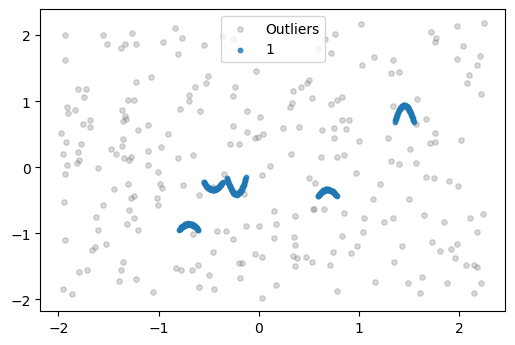

In [30]:
# ds, gt = create_dataset_line(params["npoints"], m_s=np.random.uniform(-3, 3, size=(params["nmodels"])), centers=np.random.uniform(-30, 30, size=(params["nmodels"], 2)), outliers_fraction=params["of"])
ds, gt = create_dataset_parabola(params["npoints"], a_s=np.random.uniform(-3, 3, size=(params["nmodels"])), centers=np.random.uniform(-30, 30, size=(params["nmodels"], 2)), outliers_fraction=params["of"])

ds = normalize_points(ds)
gt[gt > 1] = 1
plot_clusters(gt, ds)

In [40]:
ran = NeuralRansac(data=ds, model_name=NN, v=NEW_INLIERS)
scores = ran.anomaly_detection(k_max=200, mss=10, epochs=100)
scores_old = scores.copy()

--------------------------------------------------
Building RanSac models
Iteration 200/200: [==============================] (100%) ETA: 0:06:55.131574 Len best cons: 4877
--------------------------------------------------
Building preference matrix
--------------------------------------------------
Building Voronoi Forest
--------------------------------------------------
Done


In [41]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

# print(np.sum(scores))
# scores = softmax(scores)
# print(np.sum(scores))

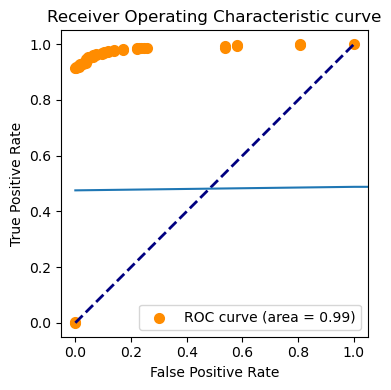

In [50]:
from sklearn.metrics import roc_curve, auc
scores_norm = softmax(scores_old)
fpr, tpr, thr = roc_curve(1-gt, scores)
roc_auc: float = auc(fpr, tpr)

lw = 2
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111, aspect='equal')

ax.scatter(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.axis('equal')
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.tight_layout()

stop = 1
plt.plot([i for i in range(len(thr)-stop)], np.sort(thr[stop:]))

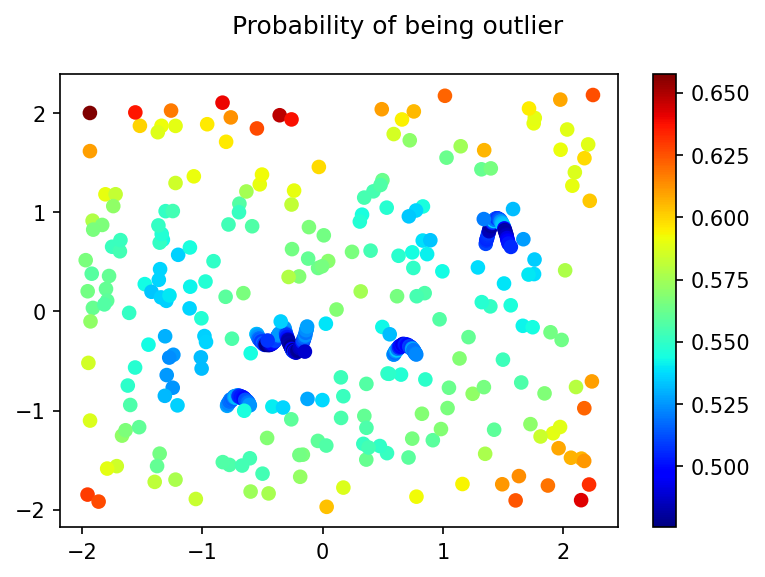

In [49]:
fig = plt.figure(dpi=150)
fig.suptitle("Probability of being outlier")
fig.tight_layout()
plt.scatter(ds[:,0], ds[:,1], c=scores, cmap="jet")
plt.colorbar()

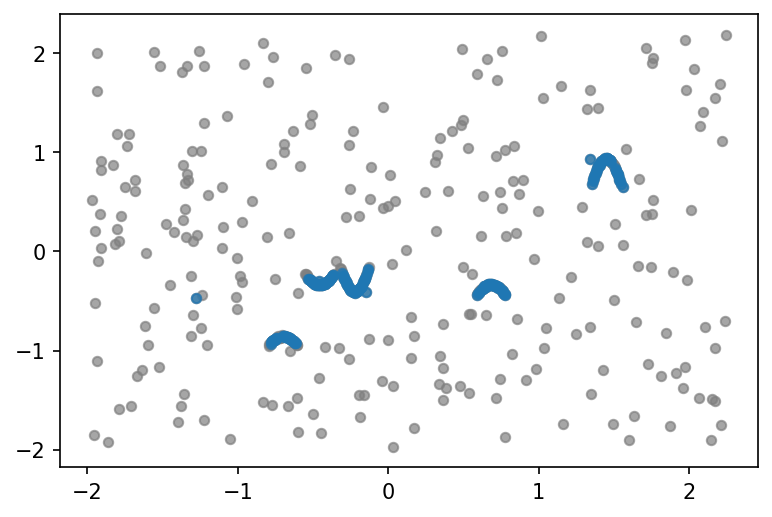

In [48]:
inliers = ds[scores_norm <= thr[28]]
plot(ds, c='gray', new_fig=True)
plot(inliers)

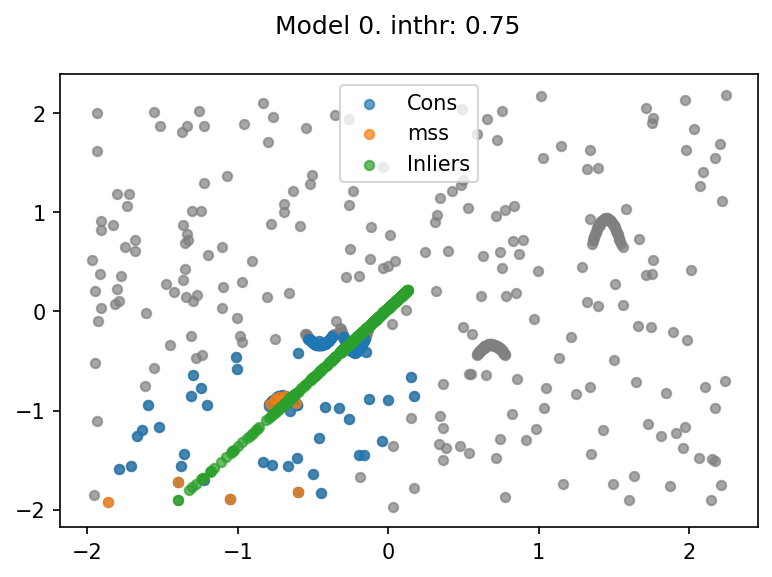

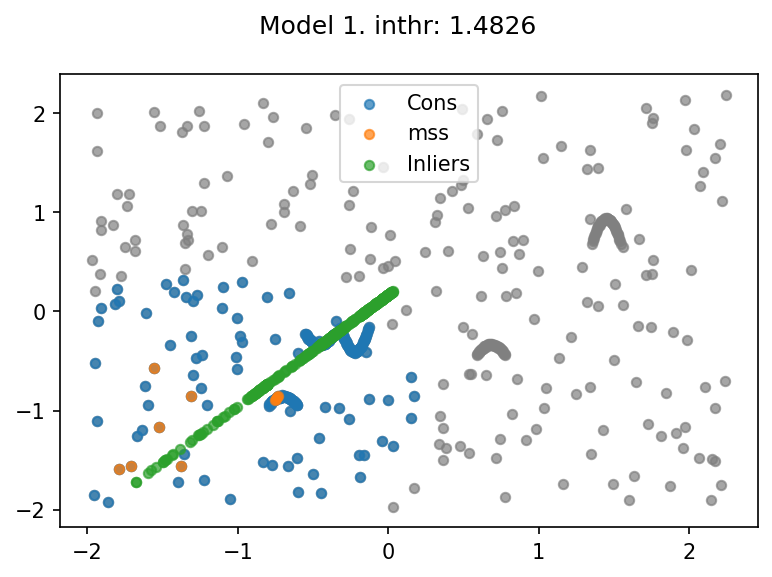

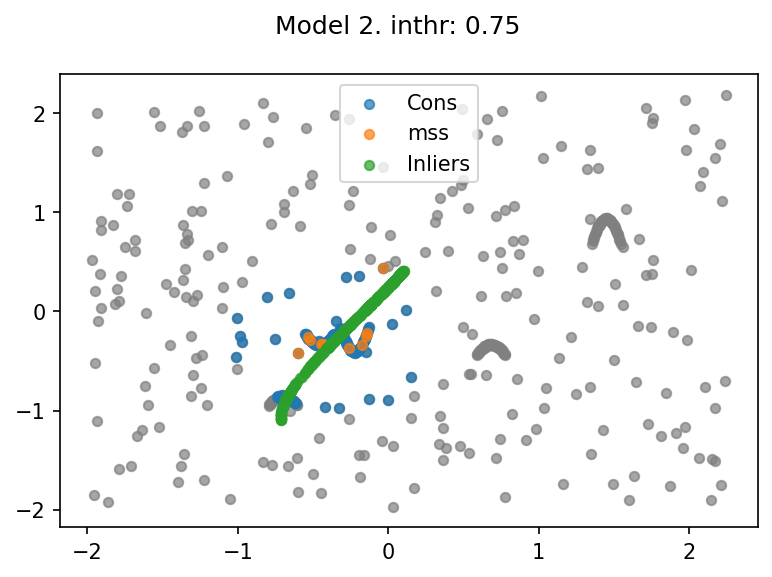

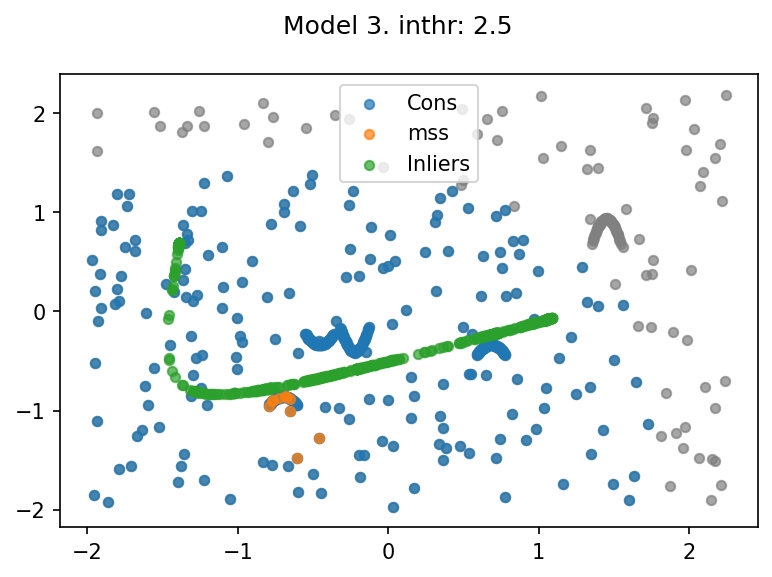

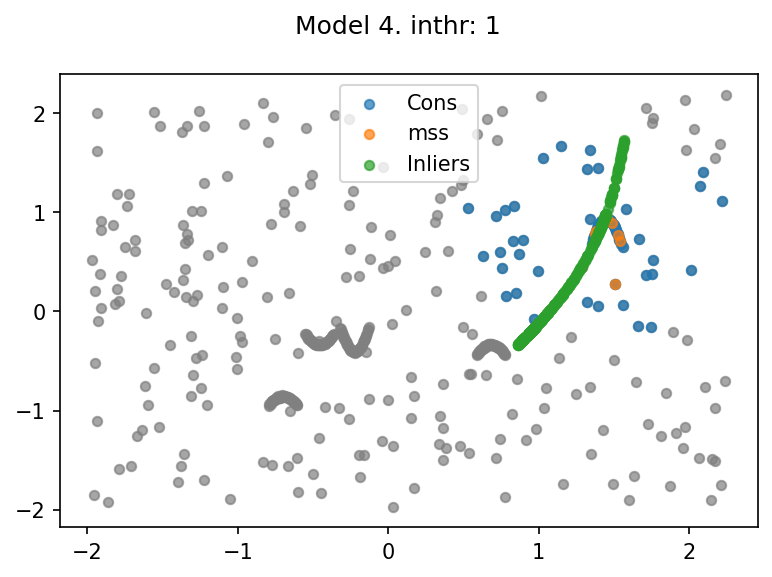

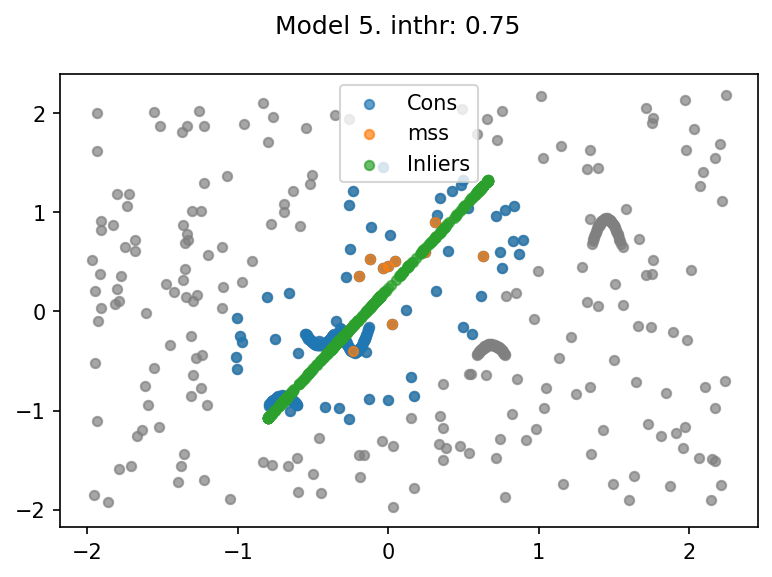

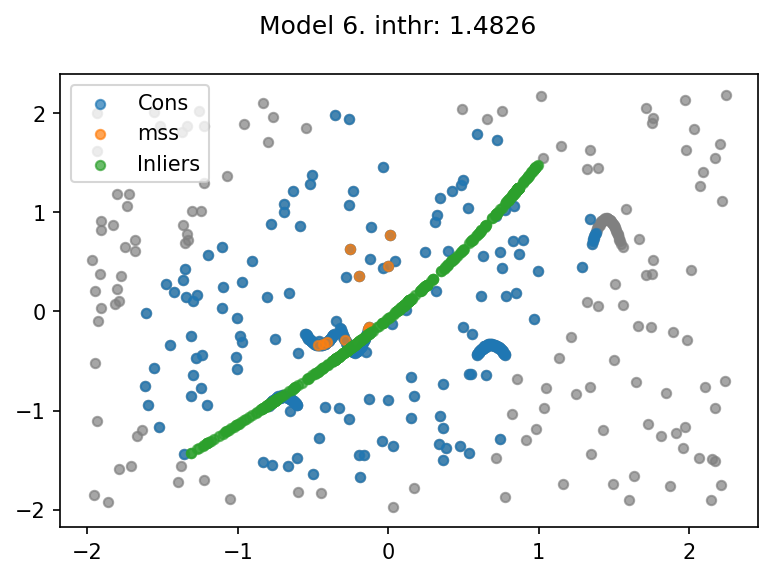

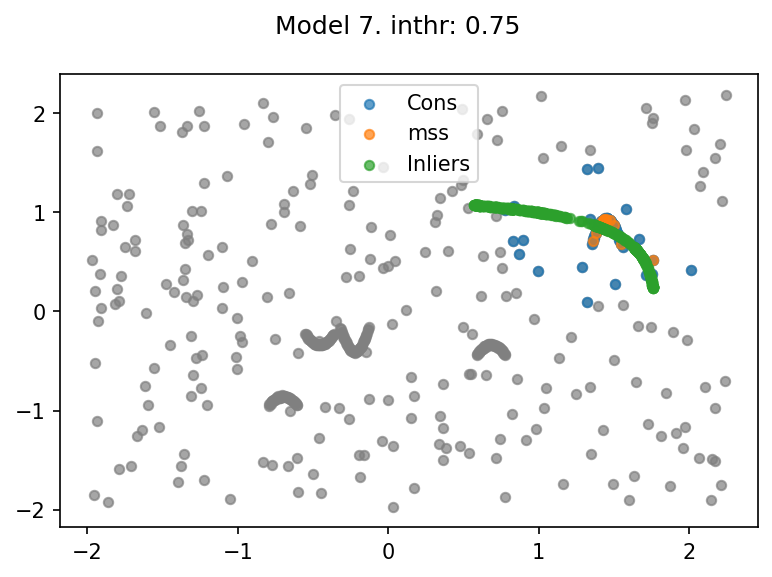

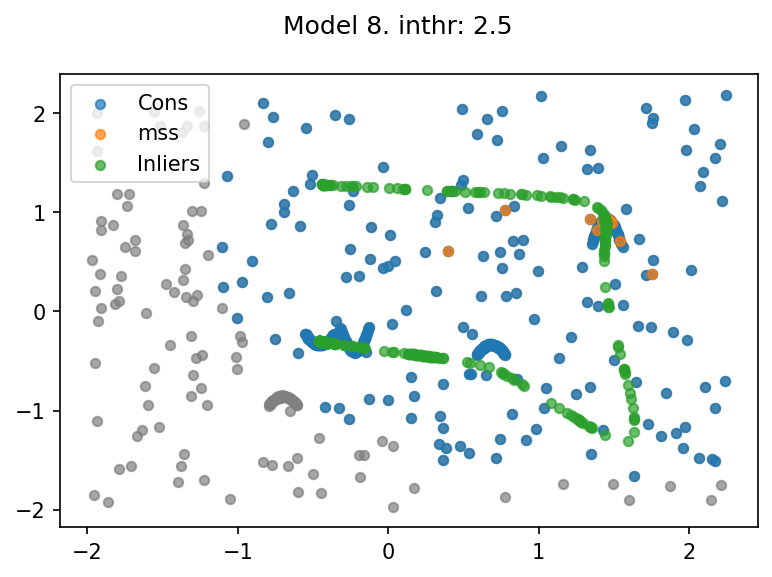

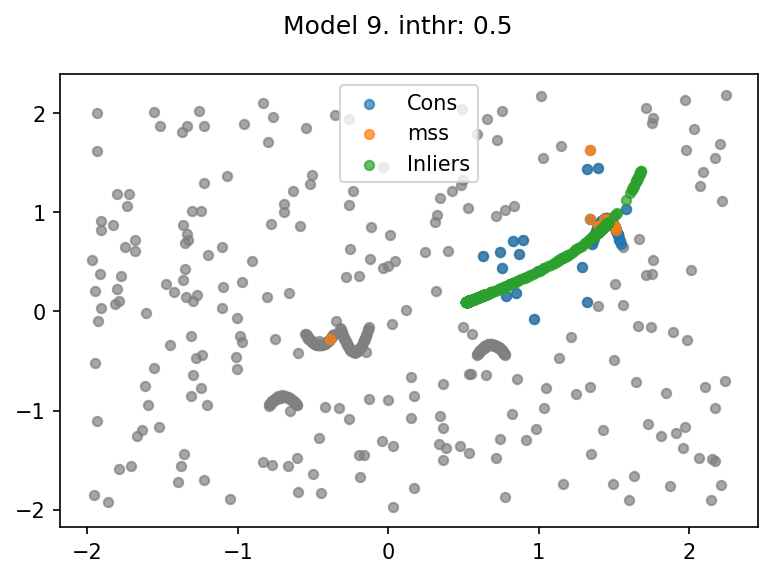

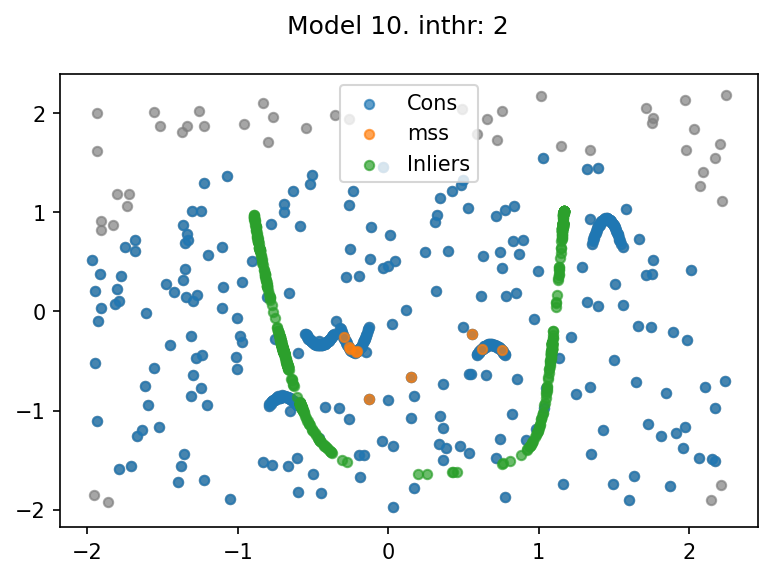

In [45]:
for i, (model, (cons, mss, inthr)) in enumerate(ran.models.items()):
    if i>10: break
    plot(ds, new_fig=True, title=f"Model {i}. inthr: {inthr}", c="gray")
    plot(cons, label="Cons")
    plot(mss, label="mss")
    plot(model.predict(ds), label="Inliers")